# Importing the libraries

In [891]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import os, sys

import fire

import sys
import os
import json
import matplotlib.pyplot as plt
import re
import string

import matplotlib.dates as mdates
import seaborn as sns

# to view all columns
pd.set_option("display.max.columns", None)

import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
from datetime import datetime, date, time, timedelta
from collections import Counter
import sys


import preprocessor as p

# Scrapping user handles from the 2 html sites

In [10]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('findaing all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res
    
def get_tag_elements(url, tag='h2'):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    response = simple_get(url)

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        names = set()
        for li in html.select(tag):
            for name in li.text.split('\n'):
                if len(name) > 0:
                    names.add(name.strip())
        return list(names)

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url)) 
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

## 1. 100 most influencial
scrapping from the Africa Freak website


In [11]:
# scrapping from the Africa Freak website
url= 'https://africafreak.com/100-most-influential-twitter-users-in-africa'
url = simple_get(url)
top_100 = get_elements(url, tag = 'h2', search  = {})
top_100[0:4]

['100. Jeffrey Gettleman (@gettleman)',
 '99. Africa24 Media (@a24media)',
 '98. Scapegoat (@andiMakinana)',
 '97. Africa Check (@AfricaCheck)']

In [12]:
#make a list of numbers from the data
splitt = [entry.split('.') for entry in top_100]
numbers = [list[0] for list in splitt]

#make a list of handles from the data
splitt = [entry.split('(') for entry in top_100]
users = [list[-1] for list in splitt]
users = [entry.split(')') for entry in users]
users = [list[0] for list in users]

#make a list of user names from the data
names = [entry.split('.') for entry in top_100]
names = [list[-1] for list in names]
names = [entry.split('(') for entry in names]
names = [list[0] for list in names]


In [13]:
print('last four ranks:', numbers[0:4])
print('last four handles:', users[0:4])
print('last four user names:', names[0:4])

last four ranks: ['100', '99', '98', '97']
last four handles: ['@gettleman', '@a24media', '@andiMakinana', '@AfricaCheck']
last four user names: [' Jeffrey Gettleman ', ' Africa24 Media ', ' Scapegoat ', ' Africa Check ']


### Creating a dataframe from the lists generated

In [14]:
data = {'users':users, 'names':names, 'ranks':numbers}
top_100 = pd.DataFrame(data)
top_100.drop(top_100.tail(5).index,inplace=True)
top_100.to_csv('top_100.csv')
top_100.tail()

,users,names,ranks
95,@Julius_S_Malema,Julius Sello Malema,5
96,@News24,News24,4
97,@SAPresident,Zuma,3
98,@GarethCliff,Gareth Cliff,2
99,@Trevornoah,Trevor Noah,1


In [15]:
# top 10 influencers
influencers = top_100.tail(10)
influencers.to_csv('top10_from_top100.csv')
influencers

,users,names,ranks
90,@Computicket,Computicket,10
91,@loyisogola,loyiso gola,9
92,@5FM,5FM,8
93,@mailandguardian,mailandguardian,7
94,@helenzille,Helen Zille,6
95,@Julius_S_Malema,Julius Sello Malema,5
96,@News24,News24,4
97,@SAPresident,Zuma,3
98,@GarethCliff,Gareth Cliff,2
99,@Trevornoah,Trevor Noah,1


## 2. African Leaders response to covid
scrapping from the Atlantic Council website

In [885]:
# scrapping from the Atlantic Council website
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/'
names = get_elements(url, tag ='a', search={'class':'css-4rbku5 css-18t94o4 css-1dbjc4n r-1loqt21 r-1wbh5a2 r-dnmrzs r-1ny4l3l'})
names = get_elements(url, tag ='div', search={})
names[80:100]

['Namibia',
 'Fellow Namibians, I declared a State of Emergency on #COVID19. Cabinet approved additonal measures and responses to contain the spread of the Coronavirus. pic.twitter.com/OsjrguArxf— Hage G. Geingob (@hagegeingob) March 18, 2020',
 'Seychelles',
 '#COVID19measuresSC #PrivateSector "Government will guarantee the salaries of all employees in the private sector for the months of April, May and June. A total of SCR1.2 billion has been budgeted for this intervention. Government will not approve any redundancies."— Seychelles Ministry of Finance (@FinanceSC) March 20, 2020',
 'South Africa',
 'The Minister for Cooperative Governance & Traditional Affairs (COGTA) has, in terms of section 3 of the Disaster Management Act, 2002 (Act No. 57 of 2002), made the and gazetted regulations to deal with the spread of Regulations in the Schedule. #COVID19 #CoronaVirusSA pic.twitter.com/3iPRnVebcs— PresidencyZA (@PresidencyZA) March 19, 2020',
 'Zambia',
 'Join the #SafeHands\xa0 Challenge.

In [886]:
lists = []
for elements in names:
    res = re.findall(r'\(.*?\)', elements)
    lists.append(res)

handles = []
for l in lists:
    for element in l:
        if element.startswith('(@'):
            handles.append(element.strip('(,)'))
handles[:20]

['@EswatiniGovern1',
 '@MalawiGovt',
 '@hagegeingob',
 '@FinanceSC',
 '@PresidencyZA',
 '@mohzambia',
 '@edmnangagwa',
 '@MinSantedj',
 '@hawelti',
 '@StateHouseKenya',
 '@PaulKagame',
 '@M_Farmaajo',
 '@SouthSudanGov',
 '@SudanPMHamdok',
 '@TZSpokesperson',
 '@KagutaMuseveni',
 '@angola_Mirex',
 '@willynyamitwe',
 '@Cherif_MZ',
 '@Presidence_RDC']

### DataFrame from the list 

In [889]:
data = {'handles':handles}
leaders = pd.DataFrame(data)
leaders.to_csv('leaders response.csv')
print(leaders.head())
print(leaders.shape)

            handles
0  @EswatiniGovern1
1       @MalawiGovt
2      @hagegeingob
3        @FinanceSC
4     @PresidencyZA
(216, 1)


In [890]:
top10_leaders = leaders.head(10)
top10_leaders.to_csv('top10_leaders.csv')
top10_leaders

,handles
0,@EswatiniGovern1
1,@MalawiGovt
2,@hagegeingob
3,@FinanceSC
4,@PresidencyZA
5,@mohzambia
6,@edmnangagwa
7,@MinSantedj
8,@hawelti
9,@StateHouseKenya


# Twitter scrapping of the 100 influencers and African leaders.

In [892]:
consumer_key = os.environ.get('consumer_key')
consumer_secret = os.environ.get('consumer_secret')
access_token = os.environ.get('access_token')
access_token_secret = os.environ.get('access_token_secret')

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
auth_api = API(auth)

df = pd.DataFrame(columns=['screen_name','description','number_of_tweets','following', 'followers',
                          'likes', 'retweets', 'hashtags', 'mentions'])
def get_it(account_list):
    for target in account_list: 
        item = auth_api.get_user(target)
        name = item.name
        screen_name = item.screen_name
        description = item.description
        number_of_tweets = item.statuses_count
        following = item.friends_count
        followers = item.followers_count
        
        # age of account
        account_created_date = item.created_at
        delta = datetime.utcnow() - account_created_date
        account_age_days = delta.days
        if account_age_days > 0:
            avg_tweets_per_day = float(number_of_tweets)/float(account_age_days)


        # tweets (hashtags and mentions)
        # making them global in order to intergrate them to the df later (or use another method)
        global hashtags, mentions, replies, comments  
        hashtags = []
        mentions = []
        comments = []
        retweet_count = []
        likes_count = []
        replies = []

        tweet_count = 0
        end_date = datetime.utcnow() - timedelta(days=180)
        for status in Cursor(auth_api.user_timeline, id=target, include_rts=False).items():                
            tweet_count += 1
            if hasattr(status, "entities"):
                entities = status.entities

    #     process_status(status)
            #hashtags
            if "hashtags" in entities:
                for ent in entities["hashtags"]:
                    if ent is not None:
                        if "text" in ent:
                            hashtag = ent["text"]
                            if hashtag is not None:
                                  hashtags.append(hashtag)

            #mentions  (will fetch other users but will later use to do mention counts between the involved users)                   
            if "user_mentions" in entities:
                for ent in entities["user_mentions"]:
                    if ent is not None:
                        if "screen_name" in ent:
                            name = ent["screen_name"]
                            if name == target:
                                if name is not None:
                                    mentions.append(name)

            # replies count                  
            if hasattr(status, "reply_count"):
                comment = status.reply_count
                if comment is not None:
                    comments.append(comment)


            # retweets count     
            if hasattr(status, "retweet_count"):
                retweets = status.retweet_count
                if retweets is not None:
                    retweet_count.append(retweets)


            # likes count     
            if hasattr(status, "favorite_count"):
                likes = status.favorite_count 
                if likes is not None:
                    likes_count.append(likes)

            # replies
            if hasattr(status, 'in_reply_to_status_id_str'):
                if (status.in_reply_to_status_id_str == status.id_str):
                    replies.append(status.text)



            # break if tweets are older than end date                 
            if status.created_at < end_date:
                break
          
            df.loc[target, ['screen_name']] = screen_name
            df.loc[target, ['description']] = description
            df.loc[target, ['number_of_tweets']] = number_of_tweets
            df.loc[target, ['following']] = following
            df.loc[target, ['followers']] = followers
            df.loc[target, ['likes']] = sum(likes_count)
            df.loc[target, ['retweets']] = sum(retweet_count)
#             df.loc[target, ['hashtags']] = hashtags
#             df.loc[target, ['mentions']] = mentions
            
#     print(hashtags)  
    return df

## 1. Get a list of active users from the 2 dataframes

In [897]:
the_100 = top_100.users.unique()
the_leaders = leaders.handles.unique()
l1 = the_100.astype(str).tolist() 
l2 = the_leaders.astype(str).tolist()
accounts = l1 + l2

# take care of private, suspended or deleted accounts
names = []
for user in accounts:
    try:
        u=auth_api.get_user(user)
        names.append(u.screen_name)
    except Exception:
            pass
names[:10]    

['gettleman',
 'a24media',
 'AndiMakinana',
 'AfricaCheck',
 'JamesCopnall',
 'oafrica',
 'PatrickNgowi',
 'stateafrica',
 'Moadow',
 'BrendanSAfrica']

## 2. Fetch their twitter data.

In [259]:
data = get_it(names)
data.to_csv('twitter_data.csv')

In [902]:
# data = data.drop_duplicates(subset='screen_name')

In [903]:
data.head()

,Unnamed: 0,Unnamed: 0.1,screen_name,description,number_of_tweets,following,followers,likes,retweets,hashtags,mentions
0,0,@gettleman,gettleman,South Asia bureau chief for the New York Times...,3766,37,25701,9267,3371,NaN,NaN
1,1,@a24media,a24media,Africa 24 produces compelling content that mak...,16852,3060,31294,603,194,NaN,NaN
2,2,@andiMakinana,AndiMakinana,In pursuit of scoops. I do not write headlines...,142183,2837,101172,73785,34232,NaN,NaN
3,3,@AfricaCheck,AfricaCheck,Africa's first independent fact-checking websi...,27294,4593,68029,7209,6857,NaN,NaN
4,4,@JamesCopnall,JamesCopnall,BBC reporter + presenter. Author A Poisonous T...,19434,5046,21960,908,161,NaN,NaN


## 3. Analysis bits.

### a). Popularity scores

Using the formulae provided in the week 1 challenge document. ***popularity_score = #retweets + #likes***

In [909]:
data['popularity'] = data['retweets'] + data['likes']
popular = data.sort_values(by = 'popularity', ascending = False)
popular.to_csv('popular_based_on_twitter.csv')
popular.head(10)

,Unnamed: 0,Unnamed: 0.1,screen_name,description,number_of_tweets,following,followers,likes,retweets,hashtags,mentions,influence_score,popularity
77,85,Trevornoah,Trevornoah,Comedian from South Africa. I was in the crowd...,11186,325,10798902,1310859,269364,NaN,NaN,10798577,1580223
74,82,Julius_S_Malema,Julius_S_Malema,Commander in Chief of Economic Freedom Fighter...,37178,652,3123242,1199508,254705,NaN,NaN,3122590,1454213
46,54,MbuyiseniNdlozi,MbuyiseniNdlozi,EFF Commissar & Member of Parliament - @EFFSou...,35887,5473,1071914,1155395,229635,NaN,NaN,1066441,1385030
110,118,MBuhari,MBuhari,This is the official account of Muhammadu Buha...,4730,26,3265988,1000482,278145,NaN,NaN,3265962,1278627
93,101,KagutaMuseveni,KagutaMuseveni,President of the Republic of Uganda,6640,28,1807416,680723,127443,NaN,NaN,1807388,808166
104,112,NAkufoAddo,NAkufoAddo,Official Twitter account of Nana Addo Dankwa A...,7086,351,1502265,538089,99677,NaN,NaN,1501914,637766
91,99,SudanPMHamdok,SudanPMHamdok,The official account of the Prime Minister of ...,649,115,368579,491083,95245,NaN,NaN,368464,586328
82,90,PresidencyZA,PresidencyZA,This is the official Twitter page of The Presi...,18839,14,1595945,337064,143158,NaN,NaN,1595931,480222
12,20,malonebarry,malonebarry,"Executive Producer, @AJStream. Previously: Al ...",35171,2988,28423,339468,120958,NaN,NaN,25435,460426
111,119,Macky_Sall,Macky_Sall,Président de la République du Sénégal 🇸🇳,2791,171,1371355,366390,57859,NaN,NaN,1371184,424249


Text(0, 0.5, 'popularity scores')

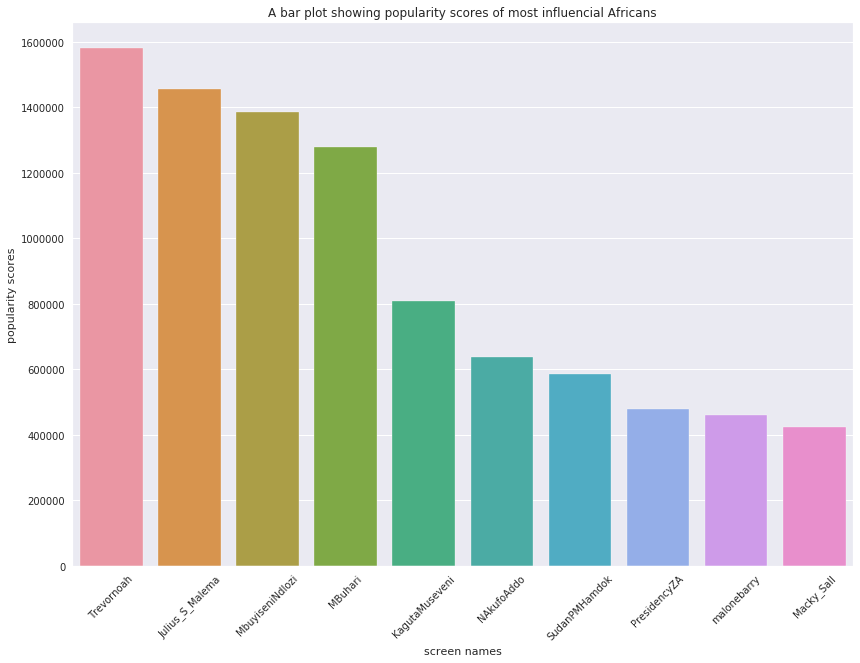

In [904]:
import seaborn as sns
import matplotlib.pyplot as plt

top_10 = popular.head(10)
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(x = top_10['screen_name'], y = top_10['popularity'], ax = ax)
plt.title('A bar plot showing popularity scores of most influencial Africans')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('popularity scores')

### b). Reach Scores
using the formule ***#followers - #they follow***

In [910]:
data['influence_score'] = data['followers'] - data['following']
most_influential = data.sort_values(by = 'influence_score', ascending = False)
most_influential.to_csv('most_influential based on twitter.csv')
most_influential.head(10)

,Unnamed: 0,Unnamed: 0.1,screen_name,description,number_of_tweets,following,followers,likes,retweets,hashtags,mentions,influence_score,popularity
77,85,Trevornoah,Trevornoah,Comedian from South Africa. I was in the crowd...,11186,325,10798902,1310859,269364,NaN,NaN,10798577,1580223
75,83,News24,News24,South Africa's premier online news resource. F...,322393,631,3573013,197685,81459,NaN,NaN,3572382,279144
110,118,MBuhari,MBuhari,This is the official account of Muhammadu Buha...,4730,26,3265988,1000482,278145,NaN,NaN,3265962,1278627
74,82,Julius_S_Malema,Julius_S_Malema,Commander in Chief of Economic Freedom Fighter...,37178,652,3123242,1199508,254705,NaN,NaN,3122590,1454213
88,96,PaulKagame,PaulKagame,"President of the Republic of Rwanda, write to:...",2861,181,1979416,194274,46499,NaN,NaN,1979235,240773
76,84,GarethCliff,GarethCliff,President of https://t.co/scMZ7lsVKF ⚜. Enquir...,31622,356,1974289,26361,5307,NaN,NaN,1973933,31668
93,101,KagutaMuseveni,KagutaMuseveni,President of the Republic of Uganda,6640,28,1807416,680723,127443,NaN,NaN,1807388,808166
65,73,euphonik,euphonik,LIFE | MUSIC | PROPERTY | BRANDS | CULTURE Con...,4510,65,1753245,223750,35389,NaN,NaN,1753180,259139
82,90,PresidencyZA,PresidencyZA,This is the official Twitter page of The Presi...,18839,14,1595945,337064,143158,NaN,NaN,1595931,480222
104,112,NAkufoAddo,NAkufoAddo,Official Twitter account of Nana Addo Dankwa A...,7086,351,1502265,538089,99677,NaN,NaN,1501914,637766


Text(0, 0.5, 'Reach scores')

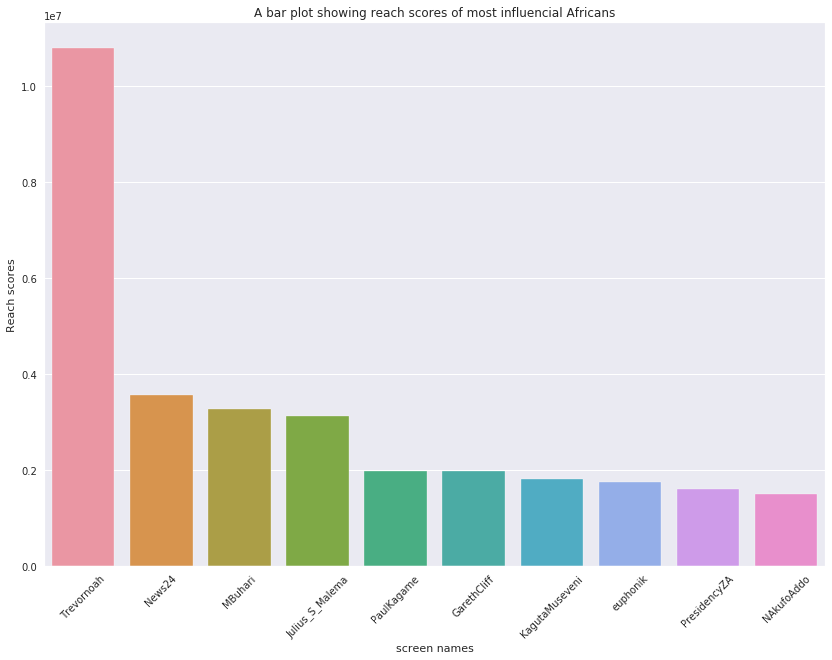

In [906]:
top_10 = most_influential.head(10)
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(x = top_10['screen_name'], y = top_10['influence_score'], ax = ax)
plt.title('A bar plot showing reach scores of most influencial Africans')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('Reach scores')

### NB: Fetch Tweets of the handles in the dataframes then create csv for each account.

The run time is really long, run it only iff you want the tweets of each of the scrapped handles.
Will be used to pull the hashtags and mentions if the first method fails.

In [33]:
consumer_key = os.environ.get('consumer_key')
consumer_secret = os.environ.get('consumer_secret')
access_token = os.environ.get('access_token')
access_token_secret = os.environ.get('access_token_secret')

def get_all_tweets(screen_name):

    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    #initialize a list to hold all the tweepy Tweets
    alltweets = []  

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name, count=200)

    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print("getting tweets before %s" % (oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200, max_id=oldest)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print("...%s tweets downloaded so far" % (len(alltweets)))

    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]

    #write the csv  
    with open('%s_tweets.csv' % screen_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)

    pass

# fetch the handles from the top_100 and leaders dataframes
# convert to list the merge them to be one list.
the_100 = top_100.users.unique()
the_leaders = leaders.handles.unique()
l1 = the_100.astype(str).tolist() 
l2 = the_leaders.astype(str).tolist()
accounts = l1 + l2

# take care of private, suspended or deleted accounts
names = []
for user in accounts:
    try:
        u=auth_api.get_user(user)
        names.append(u.screen_name)
    except Exception:
            pass
names   

# if __name__ == '__main__':
#     #pass in the username of the account you want to download
#     for i,name in enumerate(names):
#         get_all_tweets(name) 

## c). Relevance Score
***relevance_score = #retweets + #mentions in other tweets***

The function above generated tweet files (retweets inclusive) for the influencers and leaders for the past 2 years or so, from all the tweets, I plan to pull the mentions of the influencers and leaders amongst themselves and do a count of the number of times each user is mentioned.

*Using retweets in place for comments.

### c1). Mentions

In [323]:
# get the mentions from all the csvs
m = pd.DataFrame(columns=['mentions'])
def get_mentions(path): 
    data = pd.read_csv(path)
    tweets = data['text'].to_list()
    global mentions
    mentions = []
    for element in tweets:
        for string in element.split(' '):
            if string.startswith('@'):
                if len(string) > 1:
                    mentions.append(string)

    m.loc[path, 'mentions'] = mentions

    return m

file_paths = ['/home/ada/10academy/training /week1/monday/csvs/both/@' + name + '_tweets.csv' for name in names]
for path in file_paths:
    try:
        ms = get_mentions(path)
    except Exception:
        pass

In [346]:
ms.head()

,mentions
/home/ada/10academy/training /week1/monday/csvs/both/@gettleman_tweets.csv,"[@SavvyPriya:, @gettleman, @HariNYT, @KetanDay..."
/home/ada/10academy/training /week1/monday/csvs/both/@a24media_tweets.csv,"[@Yebo_Live:, @Yebo_Live:, @Yebo_Live:, @Yebo_..."
/home/ada/10academy/training /week1/monday/csvs/both/@AfricaCheck_tweets.csv,"[@gijnAfrica:, @CTICC_Official, @AfricaCheck, ..."
/home/ada/10academy/training /week1/monday/csvs/both/@JamesCopnall_tweets.csv,"[@jasonhickel:, @wasilalitaha:, @nasabdulbari,..."
/home/ada/10academy/training /week1/monday/csvs/both/@oafrica_tweets.csv,"[@A4A_Internet:, @cobbo3:, @MandGAfr\xe2\x80\x..."


In [907]:
l = ms['mentions'].to_list()
# flatten the list of lists
f_list = [y for x in l for y in x]
print('Total number of mentions in all the tweets is: ', len(f_list))

Total number of mentions in all the tweets is:  224164


In [349]:
# pick out only the mentions we're interested in and do a count of their mentions.
our_mentions = []
for mention in f_list:
    if mention in accounts:
        our_mentions.append(mention)

# do a count of each mention.
from collections import Counter
numbers = Counter(our_mentions)
len(numbers)

127

In [351]:
#create a df of mention counts
numbers = dict(numbers)
mentions_df = pd.DataFrame.from_dict(numbers, orient = 'index')
mentions_df.columns = ['mentions_count']
mentions_df = mentions_df.sort_values(by = 'mentions_count', ascending = False)
mentions_df.head(10)

,mentions_count
@gertjohan,1416
@gettleman,839
@_AfricanUnion,619
@art2gee,609
@PatrickNgowi,537
@PeterGreste,510
@liveamp,430
@GarethCliff,423
@UlrichJvV,414
@KahnMorbee,402


Text(0, 0.5, 'Number of mentions')

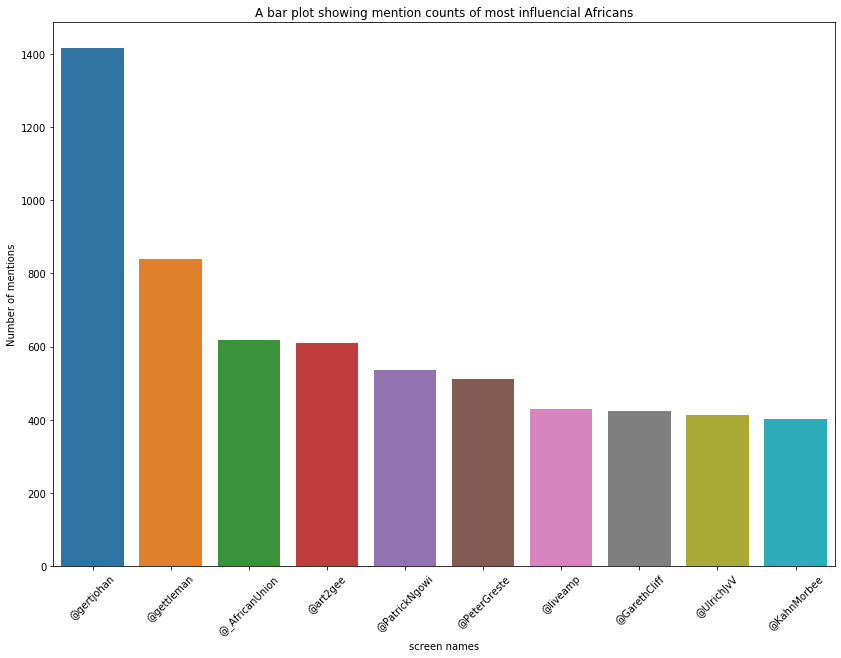

In [352]:
topp_10 = mentions_df.head(10)
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(x = topp_10.index, y = topp_10['mentions_count'], ax = ax)
plt.title('A bar plot showing mention counts of most influencial Africans')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('Number of mentions')

### c2). Retweets as proxy for comments.

check for users in the mentions dataframe and pull their details from the data dataframe then create a new dataframe with the colume 'relevance score' defined by the formulae  ***relevance_score = #retweets + #mentions in other tweets***

In [241]:
# def prepend(list, str): 
#     str += '{0}'
#     l = [str.format(i) for i in list if not i.startswith(str)] 
#     both = list+ l
#     for j in both:
#         if not j.startswith(str):
#             both.remove(j)
#     return(both) 


# l = data['Unnamed: 0.1'].to_list()
# my_list = prepend(l, '@')
# len(my_list)
# data['Unnamed: 0.1'] = my_list

In [354]:
data.head()

,Unnamed: 0,Unnamed: 0.1,screen_name,description,number_of_tweets,following,followers,likes,retweets,hashtags,mentions,popularity
0,0,@gettleman,gettleman,South Asia bureau chief for the New York Times...,3766,37,25701,9267,3371,NaN,NaN,12638
1,1,@a24media,a24media,Africa 24 produces compelling content that mak...,16852,3060,31294,603,194,NaN,NaN,797
2,2,@andiMakinana,AndiMakinana,In pursuit of scoops. I do not write headlines...,142183,2837,101172,73785,34232,NaN,NaN,108017
3,3,@AfricaCheck,AfricaCheck,Africa's first independent fact-checking websi...,27294,4593,68029,7209,6857,NaN,NaN,14066
4,4,@JamesCopnall,JamesCopnall,BBC reporter + presenter. Author A Poisonous T...,19434,5046,21960,908,161,NaN,NaN,1069


In [355]:
mentions_df = mentions_df.reset_index()
mentions_df.head()

,index,mentions_count
0,@gertjohan,1416
1,@gettleman,839
2,@_AfricanUnion,619
3,@art2gee,609
4,@PatrickNgowi,537


In [244]:
# pick out the mentions we're only interested in.
l = data['Unnamed: 0.1'].to_list()
new_mentions_df = mentions_df.loc[mentions_df['index'].isin(l)]
new_mentions_df.head()

,level_0,index,mentions_count
1,1,@gettleman,839
12,12,@Moadow,361
26,26,@JamesCopnall,232
31,31,@AfricaCheck,200
52,52,@a24media,106


In [356]:
print(data.shape)
print(mentions_df.shape)

(114, 12)
(127, 2)


In [911]:
# adding the mentions column
''' now we got two dataframes with mentions and retweets details, 
    we wish to merge them then do the relevance score. Left join will be used.
    For the columns in 'data' that don't exist in 'mentions_df', the mentions_count 
    will be filled with 0.'''

# merged = pd.merge(the_guys, new_mentions_df, on="index", how = 'inner')
merged = pd.merge(left=data, right=mentions_df, left_on='Unnamed: 0.1', right_on='index', how = 'left')
merged['mentions_count'] = merged['mentions_count'].fillna(0)
merged['relevance_score'] = merged['retweets'] + merged['mentions_count']
r_ranks = merged.sort_values(by = 'relevance_score', ascending = False)
r_ranks = r_ranks.head(10)
r_ranks

,Unnamed: 0,Unnamed: 0.1,screen_name,description,number_of_tweets,following,followers,likes,retweets,hashtags,mentions,influence_score,popularity,index,mentions_count,relevance_score
110,118,MBuhari,MBuhari,This is the official account of Muhammadu Buha...,4730,26,3265988,1000482,278145,NaN,NaN,3265962,1278627,NaN,0.0,278145.0
77,85,Trevornoah,Trevornoah,Comedian from South Africa. I was in the crowd...,11186,325,10798902,1310859,269364,NaN,NaN,10798577,1580223,NaN,0.0,269364.0
74,82,Julius_S_Malema,Julius_S_Malema,Commander in Chief of Economic Freedom Fighter...,37178,652,3123242,1199508,254705,NaN,NaN,3122590,1454213,NaN,0.0,254705.0
46,54,MbuyiseniNdlozi,MbuyiseniNdlozi,EFF Commissar & Member of Parliament - @EFFSou...,35887,5473,1071914,1155395,229635,NaN,NaN,1066441,1385030,NaN,0.0,229635.0
82,90,PresidencyZA,PresidencyZA,This is the official Twitter page of The Presi...,18839,14,1595945,337064,143158,NaN,NaN,1595931,480222,NaN,0.0,143158.0
93,101,KagutaMuseveni,KagutaMuseveni,President of the Republic of Uganda,6640,28,1807416,680723,127443,NaN,NaN,1807388,808166,NaN,0.0,127443.0
12,20,malonebarry,malonebarry,"Executive Producer, @AJStream. Previously: Al ...",35171,2988,28423,339468,120958,NaN,NaN,25435,460426,NaN,0.0,120958.0
104,112,NAkufoAddo,NAkufoAddo,Official Twitter account of Nana Addo Dankwa A...,7086,351,1502265,538089,99677,NaN,NaN,1501914,637766,NaN,0.0,99677.0
91,99,SudanPMHamdok,SudanPMHamdok,The official account of the Prime Minister of ...,649,115,368579,491083,95245,NaN,NaN,368464,586328,NaN,0.0,95245.0
75,83,News24,News24,South Africa's premier online news resource. F...,322393,631,3573013,197685,81459,NaN,NaN,3572382,279144,NaN,0.0,81459.0


Text(0, 0.5, 'relevance scores')

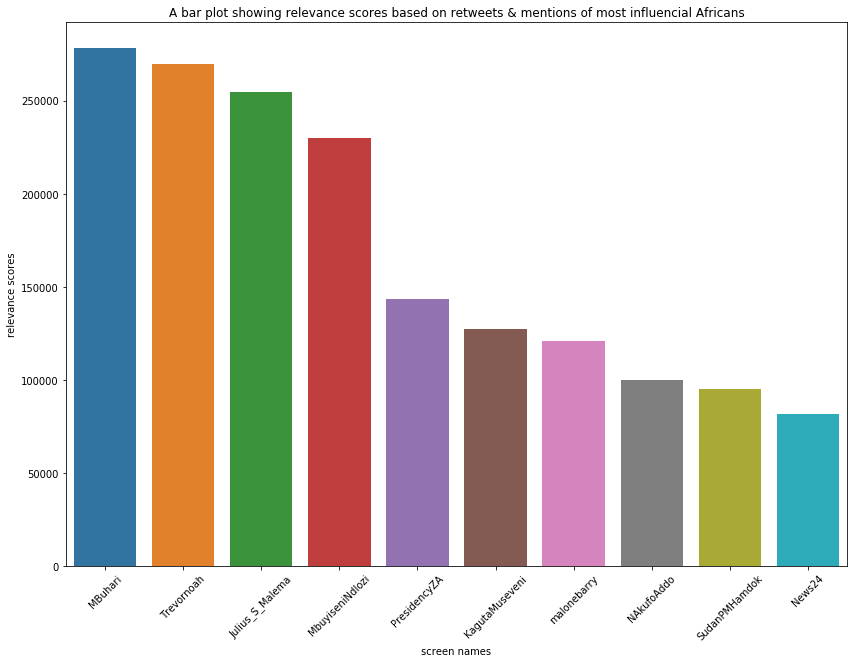

In [358]:
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(x = r_ranks['Unnamed: 0.1'], y = r_ranks['relevance_score'], ax = ax)
plt.title('A bar plot showing relevance scores based on retweets & mentions of most influencial Africans')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('relevance scores')

## d). Hashtags


In [333]:
#get the hashtags from the tweets
tags = pd.DataFrame(columns=['hashtags'])
def get_tags(path): 
    data = pd.read_csv(path)
    tweets = data['text'].to_list()
    global mentions
    hashtags = []
    for element in tweets:
        for string in element.split(' '):
            if string.startswith('#'):
                if len(string) > 1:
                    hashtags.append(string)

    tags.loc[path, 'hashtags'] = hashtags

    return tags

for path in file_paths:
    try:
        ts = get_tags(path)
    except Exception:
        pass

In [359]:
ts.head()

,hashtags
/home/ada/10academy/training /week1/monday/csvs/both/@gettleman_tweets.csv,"[#PLA, #IndianArmy,, #COVID19, #InternationalY..."
/home/ada/10academy/training /week1/monday/csvs/both/@a24media_tweets.csv,"[#tue\xe2\x80\xa6"", #YeboWatchParty, #Nkoloso,..."
/home/ada/10academy/training /week1/monday/csvs/both/@AfricaCheck_tweets.csv,"[#COVID19, #Nigeria\xe2\x80\x99s, #African, #S..."
/home/ada/10academy/training /week1/monday/csvs/both/@JamesCopnall_tweets.csv,"[#Sudan, #Sudan, #Malawi, #BBCFocusOnAfrica"", ..."
/home/ada/10academy/training /week1/monday/csvs/both/@oafrica_tweets.csv,"[#Cameroon, #BringBackOurInternet, #Kigali:, #..."


In [365]:
# add a name column (modify the index): df should represent a screen name and corresponding hashtags they use.
h = ts['hashtags'].to_list()
ts.head()

,hashtags,tags
/home/ada/10academy/training /week1/monday/csvs/both/@gettleman_tweets.csv,"[#PLA, #IndianArmy,, #COVID19, #InternationalY...","[#PLA, #IndianArmy,, #COVID19, #InternationalY..."
/home/ada/10academy/training /week1/monday/csvs/both/@a24media_tweets.csv,"[#tue\xe2\x80\xa6"", #YeboWatchParty, #Nkoloso,...","[#tue\xe2\x80\xa6"", #YeboWatchParty, #Nkoloso,..."
/home/ada/10academy/training /week1/monday/csvs/both/@AfricaCheck_tweets.csv,"[#COVID19, #Nigeria\xe2\x80\x99s, #African, #S...","[#COVID19, #Nigeria\xe2\x80\x99s, #African, #S..."
/home/ada/10academy/training /week1/monday/csvs/both/@JamesCopnall_tweets.csv,"[#Sudan, #Sudan, #Malawi, #BBCFocusOnAfrica"", ...","[#Sudan, #Sudan, #Malawi, #BBCFocusOnAfrica"", ..."
/home/ada/10academy/training /week1/monday/csvs/both/@oafrica_tweets.csv,"[#Cameroon, #BringBackOurInternet, #Kigali:, #...","[#Cameroon, #BringBackOurInternet, #Kigali:, #..."


In [379]:
# clean the index column
index_list = ts.index.to_list()
screen_names = []
for l in index_list:
    l = l.split('/')
    l = l[-1]
    screen_names.append(l)
    
ts.index = screen_names
ts = ts.reset_index()
ts.head()

,index,hashtags
0,@gettleman_tweets.csv,"[#PLA, #IndianArmy,, #COVID19, #InternationalY..."
1,@a24media_tweets.csv,"[#tue\xe2\x80\xa6"", #YeboWatchParty, #Nkoloso,..."
2,@AfricaCheck_tweets.csv,"[#COVID19, #Nigeria\xe2\x80\x99s, #African, #S..."
3,@JamesCopnall_tweets.csv,"[#Sudan, #Sudan, #Malawi, #BBCFocusOnAfrica"", ..."
4,@oafrica_tweets.csv,"[#Cameroon, #BringBackOurInternet, #Kigali:, #..."


In [382]:
names_list = ts['index'].to_list()
s_names = []
for l in names_list:
    l = l.split('_')
    l = l[0]
    s_names.append(l)

ts['index'] = s_names
ts.head()

,index,hashtags
0,@gettleman,"[#PLA, #IndianArmy,, #COVID19, #InternationalY..."
1,@a24media,"[#tue\xe2\x80\xa6"", #YeboWatchParty, #Nkoloso,..."
2,@AfricaCheck,"[#COVID19, #Nigeria\xe2\x80\x99s, #African, #S..."
3,@JamesCopnall,"[#Sudan, #Sudan, #Malawi, #BBCFocusOnAfrica"", ..."
4,@oafrica,"[#Cameroon, #BringBackOurInternet, #Kigali:, #..."


### a). Popular hashtags overall

In [418]:
tags_list = ts['hashtags'].to_list()
f_tags = [y for x in tags_list for y in x]
counts = Counter(f_tags)
counts = dict(counts)
tags_df = pd.DataFrame.from_dict(counts, orient = 'index')
tags_df.columns = ['tag_counts']
tags_df = tags_df.sort_values(by = 'tag_counts', ascending = False)
tags_df.head(15)

,tag_counts
#Africa,2183
#COVID19,2118
#IBK,1282
#Ramaphosa:,1202
#Somalia,948
#Burundi,921
#Kenya,748
#Knysna,702
#Nigeria,696
#African,599


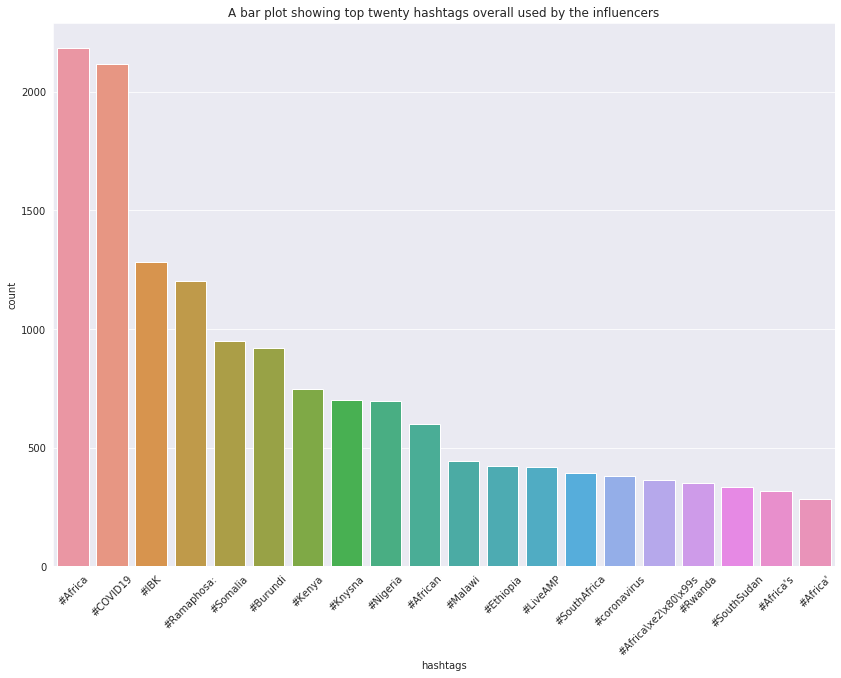

In [425]:
top_20 = tags_df.head(20)
fig, ax = plt.subplots(figsize=(14,10))
sns.barplot(x = top_20.index, y = top_20['tag_counts'], ax = ax)
plt.title('A bar plot showing top twenty hashtags overall used by the influencers')
plt.xticks(rotation=45)
plt.xlabel('hashtags')
plt.ylabel('count')
sns.set_style('whitegrid')

Other than country names, popular tags are ***covid19, coronavirus, Africa, IBK, Ramaphosa, Knysna*** and ***LiveAmp***

### b).User specific top 5 hashtags

In [550]:
''' Do a count of hashtags per person, fetch top 10 hashtags, make a df using them'''

tags_list = ts['hashtags'].to_list()
n_list = ts['index'].to_list()

tags_count = pd.DataFrame(columns = ['top_five_hashtags'])
def individual_tag_count(l, name):
    counts = Counter(l)
    top = counts.most_common(5)
    the_top_tags = [t[0] for t in top]
    tags_count.loc[name] = [the_top_tags]
    
    return tags_count

In [551]:
for l, name in zip(tags_list, n_list):
    top_tags_df = individual_tag_count(l, name)

In [552]:
top_tags_df.head()

,top_five_hashtags
@gettleman,"[#Rohingya, #India, #Kathua, #RohingyaCrisis, ..."
@a24media,"[#Africa', #Africa, #AfricaJournal, #Kenya, #T..."
@AfricaCheck,"[#SouthAfrica, #coronavirus, #Nigeria, #SouthA..."
@JamesCopnall,"[#Sudan, #SouthSudan, #Newsday, #SudanUprising..."
@oafrica,"[#Africa, #1stReads', #Rwanda, #tech, #telegeo..."


### c).Grouping individuals according to their hashtags similarities

#### Assuming 10 groups

In [553]:
''' make a big list of all the individuals top 5 hashtags, pick the top 10 out of the big list,
group the individuals based on their similarities in relation to those hashtags'''

my_list = top_tags_df['top_five_hashtags'].to_list()
flattened = [y for x in my_list for y in x]
counts = Counter(flattened)
top = counts.most_common(10)
top_10_tags = [t[0] for t in top]
top_10_tags

['#Africa',
 '#COVID19',
 '#Kenya',
 '#Somalia',
 '#coronavirus',
 '#Nigeria',
 '#Mogadishu',
 '#Ethiopia',
 '#SouthAfrica',
 '#BlackLivesMatter']

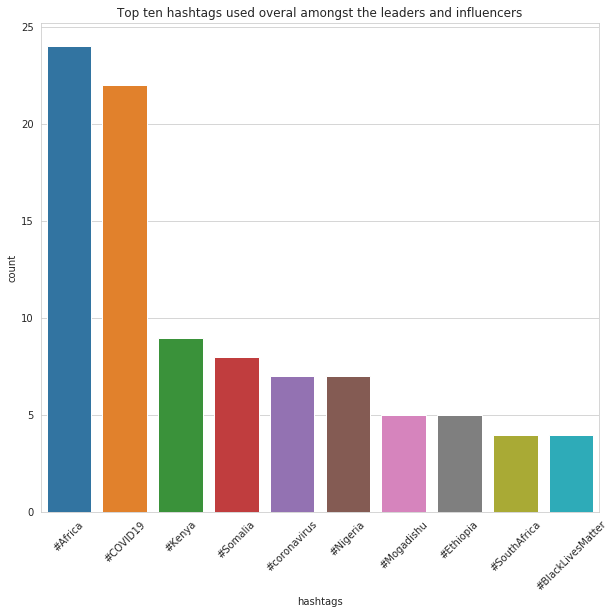

In [560]:
# top ten hashtags overall
x = [t[0] for t in top]
y = [t[1] for t in top]
fig, ax = plt.subplots(figsize=(10,9))
sns.barplot(x, y, ax = ax)
plt.title('Top ten hashtags used overal amongst the leaders and influencers')
plt.xticks(rotation=45)
plt.xlabel('hashtags')
plt.ylabel('count')
sns.set_style('whitegrid')

In [608]:
my_list = top_tags_df['top_five_hashtags'].to_list()
names_list = top_tags_df.index.to_list()

#Africa
print('#Africa guys \n')
for name, l in zip(names_list, my_list):
    if '#Africa' in l:
        print(name)
    

#Africa guys 

@a24media
@oafrica
@PatrickNgowi
@TheEIU
@InvestInAfrica
@JamalMOsman
@forbeesta
@africatechie
@ayittey
@africagathering
@Aynte
@rangerdiaries
@ThinkAfricaFeed
@AfricaGoodNews
@MadeItInAfrica
@AfricaResearch
@africaprogress
@IFCAfrica
@JendayiFrazer
@Mo
@
@Camfed
@PaulKagame
@USEmbalo


In [609]:
#COVID19
print('#COVID19 guys \n')
for name, l in zip(names_list, my_list):
    if '#COVID19' in l:
        print(name)

#COVID19 guys 

@CityTshwane
@malonebarry
@equal
@africatechie
@GautengProvince
@willintune
@cnbcafrica
@MbuyiseniNdlozi
@IFCAfrica
@geoffreyyork
@
@Camfed
@mailandguardian
@EswatiniGovern1
@FinanceSC
@PresidencyZA
@edmnangagwa
@MinSantedj
@PaulKagame
@SouthSudanGov
@KagutaMuseveni
@Presidency


In [610]:
#Kenya
print('#Kenya guys \n')
for name, l in zip(names_list, my_list):
    if '#Kenya' in l:
        print(name)

#Kenya guys 

@a24media
@Moadow
@t
@Hamza
@ThinkAfricaFeed
@AfricaResearch
@JendayiFrazer
@NDOCKenya
@M


In [611]:
#Somalia
print('#Somalia guys \n')
for name, l in zip(names_list, my_list):
    if '#Somalia' in l:
        print(name)

#Somalia guys 

@Moadow
@JamalMOsman
@t
@forbeesta
@Hamza
@mary
@Aynte
@M


In [612]:
#coronavirus
print('#coronavirus guys \n')
for name, l in zip(names_list, my_list):
    if '#coronavirus' in l:
        print(name)

#coronavirus guys 

@AfricaCheck
@malonebarry
@Hamza
@MbuyiseniNdlozi
@geoffreyyork
@hartleyr
@PresidentBio


In [613]:
#Nigeria
print('#Nigeria guys \n')
for name, l in zip(names_list, my_list):
    if '#Nigeria' in l:
        print(name)

#Nigeria guys 

@AfricaCheck
@TheEIU
@InvestInAfrica
@ThinkAfricaFeed
@AfricaResearch
@JendayiFrazer
@MBuhari


In [614]:
#Mogadishu
print('#Mogadishu guys \n')
for name, l in zip(names_list, my_list):
    if '#Mogadishu' in l:
        print(name)

#Mogadishu guys 

@Moadow
@Hamza
@mary
@Aynte
@M


In [615]:
#Ethiopia
print('#Ethiopia guys \n')
for name, l in zip(names_list, my_list):
    if '#Ethiopia' in l:
        print(name)

#Ethiopia guys 

@Moadow
@JamalMOsman
@mary
@willintune
@geoffreyyork


In [607]:
#SouthAfrica
print('#SouthAfrica guys \n')
for name, l in zip(names_list, my_list):
    if '#SouthAfrica' in l:
        print(name)

#SouthAfrica guys 

@AfricaCheck
@TheEIU
@forbeesta
@hartleyr


In [606]:
#BlackLivesMatter
print('#BlackLivesMatter guys \n')
for name, l in zip(names_list, my_list):
    if '#BlackLivesMatter' in l:
        print(name)

#BlackLivesMatter guys 

@malonebarry
@iamsuede
@MbuyiseniNdlozi
@mailandguardian


### d). A bar plot to show the fraction of influencers and top government officials by hashtag.

In [617]:
blm = ['@malonebarry', '@iamsuede', '@MbuyiseniNdlozi', '@mailandguardian']
sa = ['@AfricaCheck','@TheEIU', '@forbeesta', '@hartleyr']
ethiopia = ['@Moadow', '@JamalMOsman', '@mary', '@willintune', '@geoffreyyork']
mogadishu = ['@Moadow', '@Hamza', '@mary', '@Aynte', '@M']
nigeria = ['@AfricaCheck', '@TheEIU', '@InvestInAfrica', '@ThinkAfricaFeed', '@AfricaResearch', '@JendayiFrazer', '@MBuhari']
rona = ['@AfricaCheck', '@malonebarry', '@Hamza', '@MbuyiseniNdlozi', '@geoffreyyork', '@hartleyr', '@PresidentBio']
somalia = ['@Moadow', '@JamalMOsman', '@t', '@forbeesta', '@Hamza', '@mary', '@Aynte', '@M']
kenya = ['@a24media', '@Moadow', '@t', '@Hamza', '@ThinkAfricaFeed', '@AfricaResearch', '@JendayiFrazer', '@NDOCKenya','@M']
covid = ['@CityTshwane', '@malonebarry', '@equal', '@africatechie', '@GautengProvince', '@willintune', '@cnbcafrica', '@MbuyiseniNdlozi',
         '@IFCAfrica', '@geoffryyork', '@Camfed', '@mailandguardian', '@EswatiniGovern1', '@FinanceSC', 
         '@PresidencyZA', '@edmnangagwa', '@MinSantedj', '@PaulKagame', '@SouthSudanGov', '@KagutaMuseveni', '@Presidency']
africa = ['@a24media', '@oafrica', '@PatrickNgowi', '@TheEIU', '@InvestInAfrica', '@JamalMOsman', '@forbeesta', '@africatechie',
          '@ayittey', '@africagathering', '@Aynte', '@rangerdiaries', '@ThinkAfricaFeed', '@AfricaGoodNews', '@MadeItInAfrica'
          '@AfricaResearch', '@africaprogress',' @IFCAfrica', '@JendayiFrazer', '@Mo', '@Camfed', '@PaulKagame', '@USEmbalo']

In [621]:
# l1 and l2 had been defined earlier
influencers = l1
leaders = l2

In [622]:
def split(my_list):
    l = []
    i = []
    for element in my_list:
        if element in influencers:
            i.append(element)
        elif element in leaders:
            l.append(element)
            
    return l, i

In [627]:
blm_leader, blm_inf = split(blm)[0] , split(blm)[1]
sa_leader, sa_inf = split(sa)[0] , split(sa)[1]
mogadishu_leader, mogadishu_inf = split(mogadishu)[0] , split(mogadishu)[1]
nigeria_leader, nigeria_inf = split(nigeria)[0] , split(nigeria)[1]
rona_leader, rona_inf = split(rona)[0] , split(rona)[1]
somalia_leader, somalia_inf = split(somalia)[0] , split(somalia)[1]
kenya_leader, kenya_inf = split(kenya)[0] , split(kenya)[1]
covid_leader, covid_inf = split(covid)[0] , split(covid)[1]
africa_leader, africa_inf = split(africa)[0] , split(africa)[1]
ethiopia_leader, ethiopia_inf = split(ethiopia)[0] , split(ethiopia)[1]

In [628]:
# plotting
tags_p = ['#Africa', '#COVID19', '#Kenya', '#Somalia', '#coronavirus', '#Nigeria', '#Mogadishu',
          '#Ethiopia', '#SouthAfrica', '#BlackLivesMatter']
leaders_plot = [len(africa_leader), len(covid_leader), len(kenya_leader), len(somalia_leader),
                len(rona_leader),  len(nigeria_leader), len(mogadishu_leader), len(ethiopia_leader),
                len(sa_leader), len(blm_leader)]
influencers_plot = [len(africa_inf), len(covid_inf), len(kenya_inf), len(somalia_inf),
                len(rona_inf),  len(nigeria_inf), len(mogadishu_inf), len(ethiopia_inf),
                len(sa_inf), len(blm_inf)]

In [636]:
d = {'tags': tags_p, 'leaders_count': leaders_plot, 'influencers_count': influencers_plot} 
df = pd.DataFrame(d)
df

,tags,leaders_count,influencers_count
0,#Africa,2,16
1,#COVID19,8,10
2,#Kenya,0,6
3,#Somalia,0,4
4,#coronavirus,1,5
5,#Nigeria,1,5
6,#Mogadishu,0,2
7,#Ethiopia,0,4
8,#SouthAfrica,0,3
9,#BlackLivesMatter,0,4


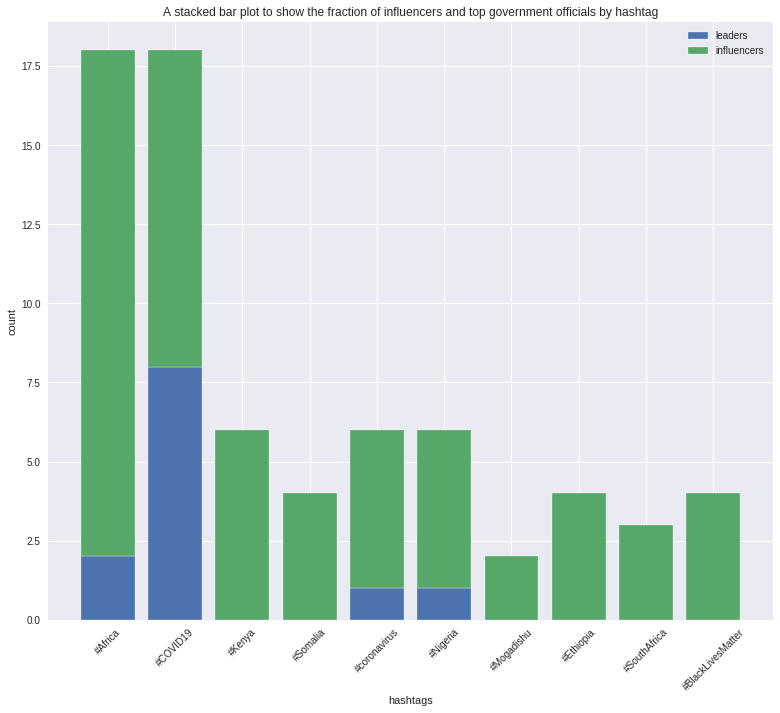

In [651]:
fig, ax = plt.subplots(figsize=(13,11))
p1 = plt.bar(df['tags'], df['leaders_count'])
p2 = plt.bar(df['tags'], df['influencers_count'], bottom=df['leaders_count'])
plt.title('A stacked bar plot to show the fraction of influencers and top government officials by hashtag')
plt.xticks(rotation=45)
plt.xlabel('hashtags')
plt.ylabel('count')
plt.legend(('leaders','influencers'))
# sns.set_style('whitegrid')
plt.style.use('ggplot')

## 4. Report specifics
Selecting guys that either appear in all the 3 grouping categories used or are part of top 5 in the categories. Then fetching their top ten hashtags and descriptions.
Most of the work is going to be repetition of what's already been done, only pinpointed to a specific group.

### Popularity, relevance, reach

In [707]:
rel = merged.head(20).sort_values(by = 'relevance_score', ascending  = False)['screen_name'].to_list()
ifn = most_influential.head(20)['screen_name'].to_list()
pop = popular.head(20)['screen_name'].to_list()
mega_list = rel + ifn + pop

top_5 = rel[:5] + ifn[:5] + pop[:5]
filtered = []
for name in mega_list:
    if mega_list.count(name) >= 2:
        filtered.append(name)

In [915]:
#check out correlation from the 3 scores
'''make a df of the 3 scores, then check how the 3 correlate using the
spearman rank correlation coefficient '''

the_3_scores = pd.DataFrame(columns = ['names', 'reach_score', 'popularity_score', 'relevance_score'])
the_3_scores['names'] = merged['screen_name']
the_3_scores['reach_score'] = merged['influence_score']
the_3_scores['popularity_score'] = merged['popularity']
the_3_scores['relevance_score'] = merged['relevance_score']
the_3_scores.head()

,names,reach_score,popularity_score,relevance_score
0,gettleman,25664,12638,4210.0
1,a24media,28234,797,300.0
2,AndiMakinana,98335,108017,34234.0
3,AfricaCheck,63436,14066,7056.0
4,JamesCopnall,16914,1069,393.0


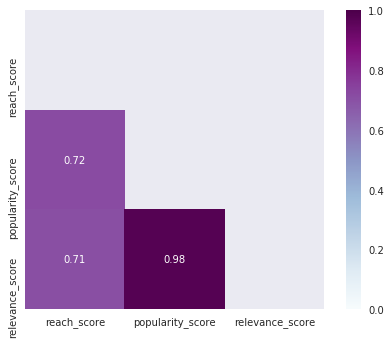

In [926]:
import numpy as np
correlation = the_3_scores.corr(method = 'spearman')
mask = np.triu(np.ones_like(correlation, dtype=np.bool))
sns.heatmap(correlation, vmin=0, vmax=1, square=True,mask = mask,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

Text(0.5, 1.0, 'A scatter plot of relevance against popularity scores')

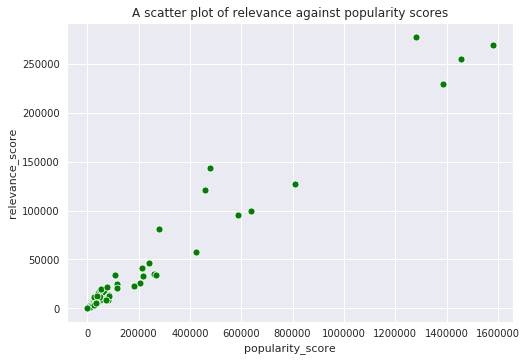

In [940]:
#line plots to view the relationship graphically
sns.scatterplot(x = the_3_scores["popularity_score"] ,y = the_3_scores['relevance_score'], color="green")
plt.title('A scatter plot of relevance against popularity scores')

Text(0.5, 1.0, 'A scatter plot of relevance against reach scores')

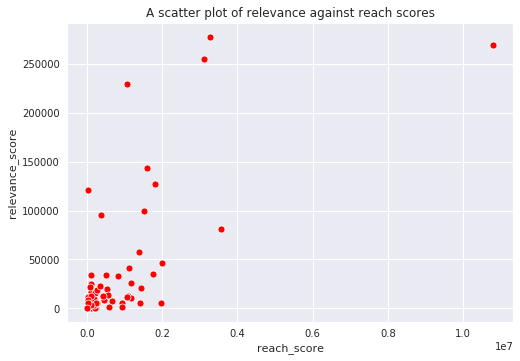

In [941]:
sns.scatterplot(x = the_3_scores["reach_score"] ,y = the_3_scores['relevance_score'], color="red")
plt.title('A scatter plot of relevance against reach scores')

Text(0.5, 1.0, 'A scatter plot of reach against popularity scores')

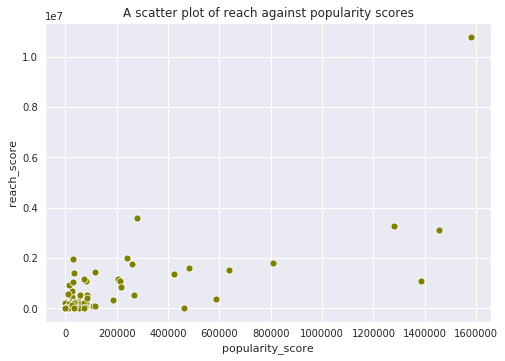

In [942]:
sns.scatterplot(x = the_3_scores["popularity_score"] ,y = the_3_scores['reach_score'], color="olive")
plt.title('A scatter plot of reach against popularity scores')

#### The correlations are high, so I'll use total scores to  pick the top 20 out of the 60.

In [945]:
the_3_scores['totals'] = the_3_scores['relevance_score'] + the_3_scores['popularity_score'] + the_3_scores['reach_score']
the_3_scores = the_3_scores.sort_values(by = 'totals', ascending = False)
the_3_scores.head()

,names,reach_score,popularity_score,relevance_score,totals
77,Trevornoah,10798577,1580223,269364.0,12648164.0
74,Julius_S_Malema,3122590,1454213,254705.0,4831508.0
110,MBuhari,3265962,1278627,278145.0,4822734.0
75,News24,3572382,279144,81459.0,3932985.0
93,KagutaMuseveni,1807388,808166,127443.0,2742997.0


In [948]:
final_list = the_3_scores.head(20)['names'].to_list()
final_list

['Trevornoah',
 'Julius_S_Malema',
 'MBuhari',
 'News24',
 'KagutaMuseveni',
 'MbuyiseniNdlozi',
 'PaulKagame',
 'NAkufoAddo',
 'PresidencyZA',
 'euphonik',
 'GarethCliff',
 'Macky_Sall',
 'helenzille',
 'MTVBaseAfrica',
 'OfficialCSA',
 'StateHouseKenya',
 '5FM',
 'loyisogola',
 'mailandguardian',
 'AOuattara_PRCI']

### Hashtags

In [949]:
tags_list = ts['hashtags'].to_list()
n_list = ts['index'].to_list()

tags_count = pd.DataFrame(columns = ['top_ten_hashtags'])
def individual_tag_count(l, name):
    counts = Counter(l)
    top = counts.most_common(10)
    the_top_tags = [t[0] for t in top]
    tags_count.loc[name] = [the_top_tags]
    
    return tags_count

In [950]:
for l, name in zip(tags_list, n_list):
    selected_tags = individual_tag_count(l, name)

In [951]:
selected_tags = selected_tags.reset_index()
selected_tags.head()

,index,top_ten_hashtags
0,@gettleman,"[#Rohingya, #India, #Kathua, #RohingyaCrisis, ..."
1,@a24media,"[#Africa', #Africa, #AfricaJournal, #Kenya, #T..."
2,@AfricaCheck,"[#SouthAfrica, #coronavirus, #Nigeria, #SouthA..."
3,@JamesCopnall,"[#Sudan, #SouthSudan, #Newsday, #SudanUprising..."
4,@oafrica,"[#Africa, #1stReads', #Rwanda, #tech, #telegeo..."


In [974]:
selected_list = final_list

def prepend(list, str): 
    str += '{0}'
    l = [str.format(i) for i in list] 
    
    return l 


my_selected_list = prepend(selected_list, '@')
tags_selected_df = pd.DataFrame(my_selected_list, columns= ['names'])
tags_selected_df.head()

,names
0,@Trevornoah
1,@Julius_S_Malema
2,@News24
3,@MbuyiseniNdlozi
4,@euphonik


In [956]:
merged_tags = pd.merge(left=selected_tags, right=tags_selected_df, left_on='index', right_on='names', how = 'inner')
merged_tags = merged_tags.drop(['index'], axis = 1)
merged_tags.head()

,top_ten_hashtags,names
0,"[#COVID19, #BREAKING, #coronavirus, #BlackLive...",@MbuyiseniNdlozi
1,"[#euNITE947, #947MixAt6, #FreshOn947, #euNITE9...",@euphonik
2,"[#ProteasWomen, #SAvENG, #ProteaFire, #SAu19s,...",@OfficialCSA
3,"[#GautengCares, #GautengCovid19, #BeProActive,...",@loyisogola
4,"[#5FMTop40, #GoodeMorning, #ForbesAndFix, #InT...",@5FM


In [957]:
l = merged_tags['top_ten_hashtags'].to_list()
flattened = [y for x in l for y in x]
counts = Counter(flattened)
top = counts.most_common(30)
top_30_overall = [t[0] for t in top]
top_30_overall

['#COVID19',
 '#coronavirus',
 '#BlackLivesMatter',
 '#Covid_19',
 '#Covid19',
 '#SupplementaryBudget',
 '#BREAKING',
 '#EFFBLMProtest',
 '#EFFBookClub',
 '#COVID19SouthAfrica',
 '#COVID__19',
 '#euNITE947',
 '#947MixAt6',
 '#FreshOn947',
 "#euNITE947'",
 '#euNITE947.',
 '#euNITE947!',
 '#947MixAt6.',
 '#euNITE947,',
 '#euNITE947\\nStream',
 '#947mixat6',
 '#ProteasWomen',
 '#SAvENG',
 '#ProteaFire',
 '#SAu19s',
 '#AlwaysRising',
 '#U19CWC',
 '#FutureStars',
 '#T20WorldCup',
 '#WeAreMore']

Text(0, 0.5, 'count')

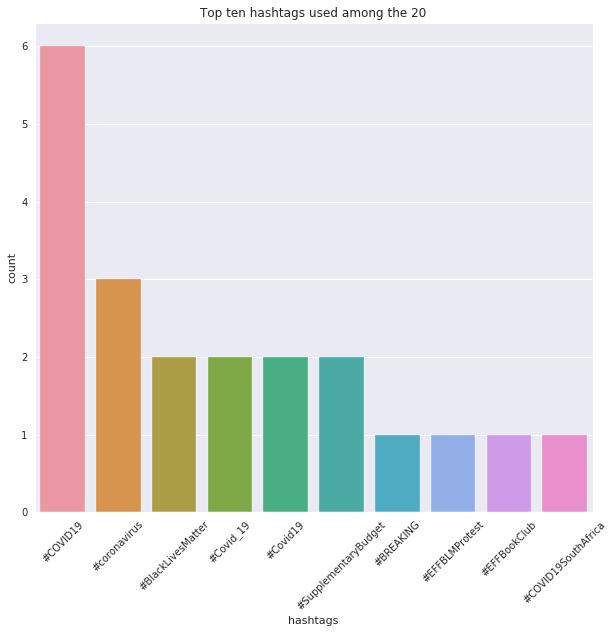

In [962]:
x = [t[0] for t in top][0:10]
y = [t[1] for t in top][0:10]
fig, ax = plt.subplots(figsize=(10,9))
sns.barplot(x, y, ax = ax)
plt.title('Top ten hashtags used among the 20')
plt.xticks(rotation=45)
plt.xlabel('hashtags')
plt.ylabel('count')
# sns.set_style('darkgrid')
# plt.style.use('seaborn-pastel')

Text(0, 0.5, 'count')

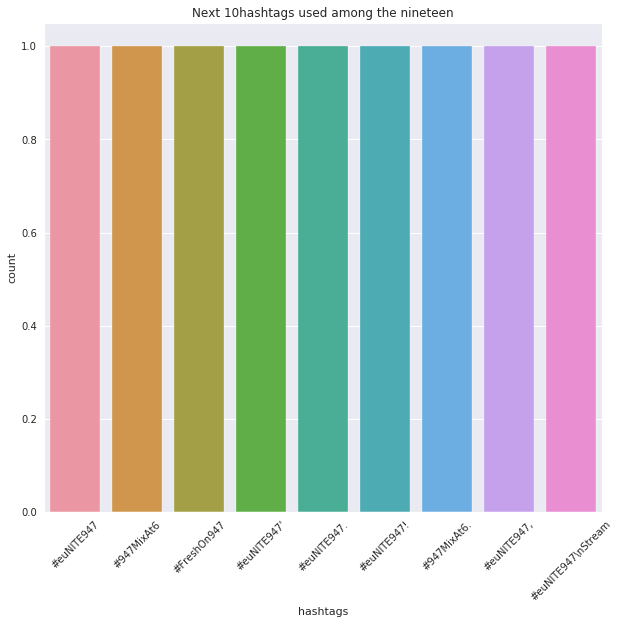

In [959]:
x = [t[0] for t in top][11:20]
y = [t[1] for t in top][11:20]
fig, ax = plt.subplots(figsize=(10,9))
sns.barplot(x, y, ax = ax)
plt.title('Next 10hashtags used among the nineteen')
plt.xticks(rotation=45)
plt.xlabel('hashtags')
plt.ylabel('count')

Text(0, 0.5, 'count')

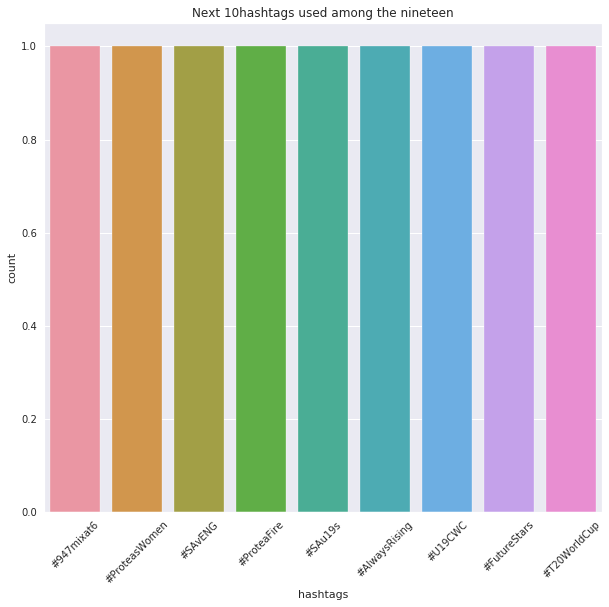

In [960]:
x = [t[0] for t in top][20:-1]
y = [t[1] for t in top][20:-1]
fig, ax = plt.subplots(figsize=(10,9))
sns.barplot(x, y, ax = ax)
plt.title('Next 10hashtags used among the nineteen')
plt.xticks(rotation=45)
plt.xlabel('hashtags')
plt.ylabel('count')

### Description

In [987]:
selected_list = final_list

# def prepend(list, str): 
#     str += '{0}'
#     l = [str.format(i) for i in list if not i.startswith(str)] 

#     return l 
# my_list = prepend(selected_list, '@')
the_19_df = pd.DataFrame(selected_list, columns= ['names'])
the_19_df.shape

(12, 1)

In [988]:
df = pd.read_csv('/home/ada/10academy/training /week1/monday/might need csvs/twitter_data.csv')
df.head()

,Unnamed: 0,screen_name,description,number_of_tweets,following,followers,likes,retweets,hashtags,mentions
0,@gettleman,gettleman,South Asia bureau chief for the New York Times...,3766,37,25701,9267,3371,NaN,NaN
1,@a24media,a24media,Africa 24 produces compelling content that mak...,16852,3060,31294,603,194,NaN,NaN
2,@andiMakinana,AndiMakinana,In pursuit of scoops. I do not write headlines...,142183,2837,101172,73785,34232,NaN,NaN
3,@AfricaCheck,AfricaCheck,Africa's first independent fact-checking websi...,27294,4593,68029,7209,6857,NaN,NaN
4,@JamesCopnall,JamesCopnall,BBC reporter + presenter. Author A Poisonous T...,19434,5046,21960,908,161,NaN,NaN


In [989]:
description_df =pd.merge(left = df, right = the_19_df, left_on = 'screen_name', right_on = 'names', how = 'inner')
description_df = description_df.drop_duplicates(subset=['screen_name'], keep=False)
description_df = description_df.drop(['Unnamed: 0', 'number_of_tweets', 'following', 'followers', 'likes', 'retweets', 'hashtags', 'mentions', 'names'], axis = 1)
description_df.head()

,screen_name,description
0,MbuyiseniNdlozi,EFF Commissar & Member of Parliament - @EFFSou...
1,euphonik,LIFE | MUSIC | PROPERTY | BRANDS | CULTURE Con...
2,OfficialCSA,The official Cricket South Africa Twitter prof...
3,MTVBaseAfrica,Uniting Africa through music & taking African ...
4,loyisogola,2 time Emmy nominated stand up comedian from S...


#### Removing the presidents from the list.

In [991]:
desc_list = description_df['description'].to_list()
screen_list = description_df['screen_name'].to_list()

#make list of lists
def extractDigits(lst): 
    return [[el] for el in lst] 

d_list = extractDigits(desc_list)
s_list = extractDigits(screen_list)

# take care of the presidents, can't run a campaign with them, they're busy serving the nation or playing house.
p = []
for name, l in zip(s_list, d_list):
    if any("Président" in str(s) for s in l):
#     bummers = ['Président' or 'president' or 'President' or 'Presidency' or 'presidency' or 'président']
        p.append(name)
    elif any("president" in str(s) for s in l):
        p.append(name)
    elif any("President" in str(s) for s in l):
        p.append(name)
    elif any("Presidency" in str(s) for s in l):
        p.append(name)
    elif any("presidency" in str(s) for s in l):
        p.append(name)            
    elif any("président" in str(s) for s in l):
        p.append(name) 


In [992]:
flattened_p = [y for x in p for y in x]
for element in flattened_p:
    selected_list.remove(element)
selected_list

['Trevornoah',
 'Julius_S_Malema',
 'News24',
 'MbuyiseniNdlozi',
 'euphonik',
 'helenzille',
 'MTVBaseAfrica',
 'OfficialCSA',
 'StateHouseKenya',
 '5FM',
 'loyisogola',
 'mailandguardian']

In [993]:
r = description_df.loc[description_df['screen_name'].isin(selected_list)]
r

,screen_name,description
0,MbuyiseniNdlozi,EFF Commissar & Member of Parliament - @EFFSou...
1,euphonik,LIFE | MUSIC | PROPERTY | BRANDS | CULTURE Con...
2,OfficialCSA,The official Cricket South Africa Twitter prof...
3,MTVBaseAfrica,Uniting Africa through music & taking African ...
4,loyisogola,2 time Emmy nominated stand up comedian from S...
5,5FM,Using the power of music to bring youthful Sou...
6,mailandguardian,"News, comment and analysis from Africa's best ..."
7,helenzille,"GodZille, GranZille, ex-Premier, ex-Mayor of C..."
8,Julius_S_Malema,Commander in Chief of Economic Freedom Fighter...
9,News24,South Africa's premier online news resource. F...


In [994]:
# cm = sns.light_palette("red", as_cmap=True)
t = r.style.background_gradient()
t

,screen_name,description
0,MbuyiseniNdlozi,EFF Commissar & Member of Parliament - @EFFSouthAfrica Economic Freedom In Our Life Time. Supporter of BDS - Free Palestine!
1,euphonik,LIFE | MUSIC | PROPERTY | BRANDS | CULTURE Contact: hello@euphonik.dj / +27797993736
2,OfficialCSA,The official Cricket South Africa Twitter profile. CSA are the custodians of cricket in South Africa.
3,MTVBaseAfrica,Uniting Africa through music & taking African music to the world! Follow @MTVBaseSouth @MTVBaseEast @MTVNewsISH @MTVBaseWest @MTVBaseFranco
4,loyisogola,2 time Emmy nominated stand up comedian from South Africa. info@loyisogola.com
5,5FM,"Using the power of music to bring youthful South Africans together! Live Loud with us on radio, web, DSTV 805 or our mobile app. WhatsApp: 0825505151"
6,mailandguardian,"News, comment and analysis from Africa's best read. Retweet not endorsement. Need reliable info on Covid-19? https://t.co/Cyj52wvMy1"
7,helenzille,"GodZille, GranZille, ex-Premier, ex-Mayor of Cape Town, Liberal, Author #NotWithoutAFight. Re-Tweets and Likes are NOT necessarily endorsements."
8,Julius_S_Malema,Commander in Chief of Economic Freedom Fighters [EFF] and a Revolutionary activist for radical change in Africa. No Facebook Account. fools get blocked
9,News24,South Africa's premier online news resource. Follow @TeamNews24 for all the action from our journalists 🇿🇦 SA's most trusted news source - Reuters Institute
